In [1]:
import json
import os
from pycocotools.coco import COCO
from shutil import copyfile
import random

In [5]:
# Define paths
annotations_file = 'data/annotations/instances_val2014.json'
images_dir = 'data/val2014'

train_output_dir = 'data_new/person_train2014/'
test_output_dir = 'data_new/person_test2014/'
train_output_annotations_file = 'data_new/annotations/person_instances_train2014.json'
test_output_annotations_file = 'data_new/annotations/person_instances_test2014.json'

# Load COCO annotations
coco = COCO(annotations_file)

# Get all category IDs and their names
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
category_id_map = {cat['name']: cat['id'] for cat in categories}

# Get the category ID for "person"
person_category_id = category_id_map['person']

# Get all image IDs that contain a person
person_image_ids = coco.getImgIds(catIds=[person_category_id])

# Define the number of images to keep for train and test sets
num_train_images = 5000
num_test_images = 150

# Randomly select a subset of the image IDs for train and test sets
selected_train_image_ids = random.sample(person_image_ids, num_train_images)
remaining_image_ids = list(set(person_image_ids) - set(selected_train_image_ids))
selected_test_image_ids = random.sample(remaining_image_ids, num_test_images)

# Get all person annotations for train and test sets
train_person_annotations = coco.loadAnns(coco.getAnnIds(imgIds=selected_train_image_ids, catIds=[person_category_id]))
test_person_annotations = coco.loadAnns(coco.getAnnIds(imgIds=selected_test_image_ids, catIds=[person_category_id]))

# Create output directories for person images
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# Copy selected person images to the output directories
for img_id in selected_train_image_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_filename = img_info['file_name']
    src_path = os.path.join(images_dir, img_filename)
    dst_path = os.path.join(train_output_dir, img_filename)
    copyfile(src_path, dst_path)

for img_id in selected_test_image_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_filename = img_info['file_name']
    src_path = os.path.join(images_dir, img_filename)
    dst_path = os.path.join(test_output_dir, img_filename)
    copyfile(src_path, dst_path)

# Save person annotations to new JSON files for train and test sets
train_person_data = {
    'images': [coco.loadImgs(img_id)[0] for img_id in selected_train_image_ids],
    'annotations': train_person_annotations,
    'categories': [cat for cat in categories if cat['id'] == person_category_id]
}

test_person_data = {
    'images': [coco.loadImgs(img_id)[0] for img_id in selected_test_image_ids],
    'annotations': test_person_annotations,
    'categories': [cat for cat in categories if cat['id'] == person_category_id]
}

# Create output directories for person images
os.makedirs(os.path.dirname(train_output_annotations_file), exist_ok=True)
os.makedirs(os.path.dirname(test_output_annotations_file), exist_ok=True)

with open(train_output_annotations_file, 'w') as f:
    json.dump(train_person_data, f)

with open(test_output_annotations_file, 'w') as f:
    json.dump(test_person_data, f)

print(f'Extracted 5000 train images and 150 test images with annotations.')


loading annotations into memory...
Done (t=3.35s)
creating index...
index created!
Extracted 5000 train images and 150 test images with annotations.


In [1]:
dataset1_annotations_file = 'data_new/annotations/person_instances_train2014.json'
dataset1_images_dir = 'data_new/person_train2014'

dataset2_annotations_file = 'data/annotations/instances_train2017.json'
dataset2_images_dir = 'data/train2017'

output_dir = 'combined_dataset/train2017/'
output_annotations_file = 'combined_dataset/annotations/instances_train2017.json'

# Create output directories if they don't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the annotations for both datasets
with open(dataset1_annotations_file, 'r') as f:
    dataset1 = json.load(f)
    
with open(dataset2_annotations_file, 'r') as f:
    dataset2 = json.load(f)

# Ensure category IDs are unique across both datasets
dataset2_category_id_offset = max(cat['id'] for cat in dataset1['categories']) + 1
dataset2_category_id_mapping = {}
for category in dataset2['categories']:
    old_id = category['id']
    category['id'] += dataset2_category_id_offset
    dataset2_category_id_mapping[old_id] = category['id']

# Adjust category names to avoid conflicts
for category in dataset1['categories']:
    category['name'] += '_normal'
for category in dataset2['categories']:
    category['name'] += '_topview'

# Merge categories
merged_categories = dataset1['categories'] + dataset2['categories']

# Ensure image IDs are unique across both datasets
dataset2_image_id_offset = max(img['id'] for img in dataset1['images']) + 1
for image in dataset2['images']:
    image['id'] += dataset2_image_id_offset

# Ensure annotation IDs are unique and update image IDs and category IDs in annotations
dataset2_annotation_id_offset = max(ann['id'] for ann in dataset1['annotations']) + 1
for annotation in dataset2['annotations']:
    annotation['id'] += dataset2_annotation_id_offset
    annotation['image_id'] += dataset2_image_id_offset
    annotation['category_id'] = dataset2_category_id_mapping[annotation['category_id']]

# Merge images and annotations
merged_images = dataset1['images'] + dataset2['images']
merged_annotations = dataset1['annotations'] + dataset2['annotations']

# Copy images to the output directory
for image in merged_images:
    src_path = os.path.join(dataset1_images_dir if image['id'] < dataset2_image_id_offset else dataset2_images_dir, image['file_name'])
    dst_path = os.path.join(output_dir, image['file_name'])
    if not os.path.exists(dst_path):
        copyfile(src_path, dst_path)

# Save the merged annotations to a new JSON file
merged_data = {
    'images': merged_images,
    'annotations': merged_annotations,
    'categories': merged_categories
}

# Make sure output path exists
if not os.path.exists(os.path.dirname(output_annotations_file)):
    os.makedirs(os.path.dirname(output_annotations_file))

with open(output_annotations_file, 'w') as f:
    json.dump(merged_data, f)

print(f'Combined dataset created with {len(merged_images)} images and {len(merged_annotations)} annotations.')


Combined dataset created with 8440 images and 54925 annotations.


In [3]:
dataset1_annotations_file = 'data_new/annotations/person_instances_test2014.json'
dataset1_images_dir = 'data_new/person_test2014'

dataset2_annotations_file = 'data/annotations/instances_test2017.json'
dataset2_images_dir = 'data/test2017'

# Output paths
output_dir = 'combined_dataset/test2017/'
output_annotations_file = 'combined_dataset/annotations/instances_test2017.json'

# Create output directories if they don't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the annotations for both datasets
with open(dataset1_annotations_file, 'r') as f:
    dataset1 = json.load(f)
    
with open(dataset2_annotations_file, 'r') as f:
    dataset2 = json.load(f)

# Ensure category IDs are unique across both datasets
dataset2_category_id_offset = max(cat['id'] for cat in dataset1['categories']) + 1
dataset2_category_id_mapping = {}
for category in dataset2['categories']:
    old_id = category['id']
    category['id'] += dataset2_category_id_offset
    dataset2_category_id_mapping[old_id] = category['id']

# Adjust category names to avoid conflicts
for category in dataset1['categories']:
    category['name'] += '_normal'
for category in dataset2['categories']:
    category['name'] += '_topview'

# Merge categories
merged_categories = dataset1['categories'] + dataset2['categories']

# Ensure image IDs are unique across both datasets
dataset2_image_id_offset = max(img['id'] for img in dataset1['images']) + 1
for image in dataset2['images']:
    image['id'] += dataset2_image_id_offset

# Ensure annotation IDs are unique and update image IDs and category IDs in annotations
dataset2_annotation_id_offset = max(ann['id'] for ann in dataset1['annotations']) + 1
for annotation in dataset2['annotations']:
    annotation['id'] += dataset2_annotation_id_offset
    annotation['image_id'] += dataset2_image_id_offset
    annotation['category_id'] = dataset2_category_id_mapping[annotation['category_id']]

# Merge images and annotations
merged_images = dataset1['images'] + dataset2['images']
merged_annotations = dataset1['annotations'] + dataset2['annotations']

# Copy images to the output directory
for image in merged_images:
    src_path = os.path.join(dataset1_images_dir if image['id'] < dataset2_image_id_offset else dataset2_images_dir, image['file_name'])
    dst_path = os.path.join(output_dir, image['file_name'])
    if not os.path.exists(dst_path):
        copyfile(src_path, dst_path)

# Save the merged annotations to a new JSON file
merged_data = {
    'images': merged_images,
    'annotations': merged_annotations,
    'categories': merged_categories
}

# Make sure output path exists
if not os.path.exists(os.path.dirname(output_annotations_file)):
    os.makedirs(os.path.dirname(output_annotations_file))

with open(output_annotations_file, 'w') as f:
    json.dump(merged_data, f)

print(f'Combined dataset created with {len(merged_images)} images and {len(merged_annotations)} annotations.')


Combined dataset created with 298 images and 1535 annotations.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


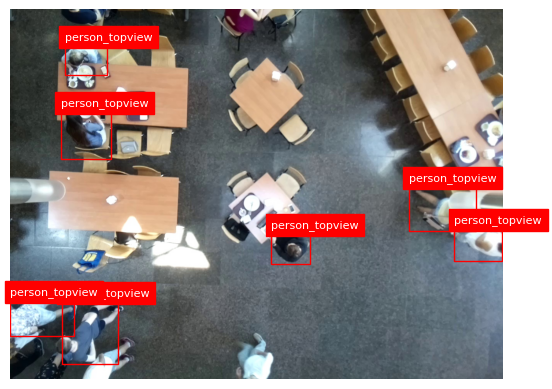

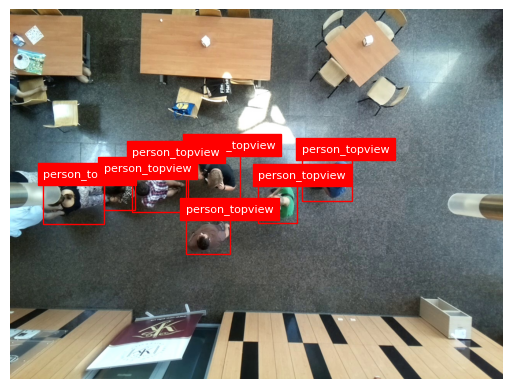

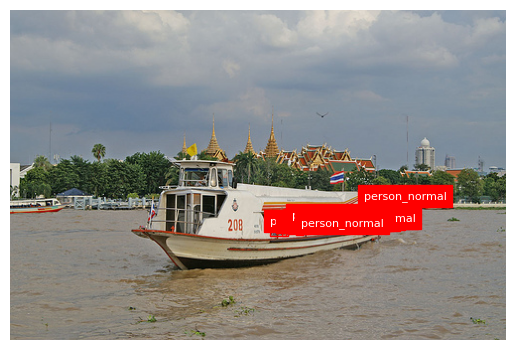

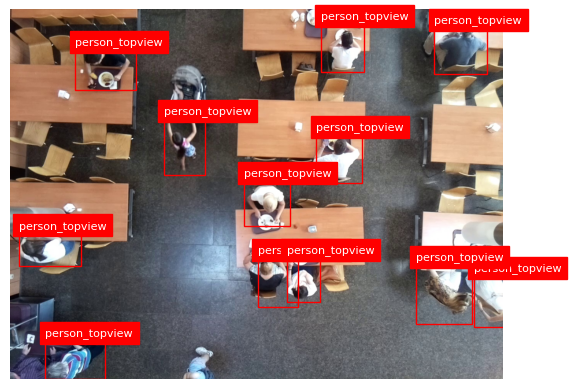

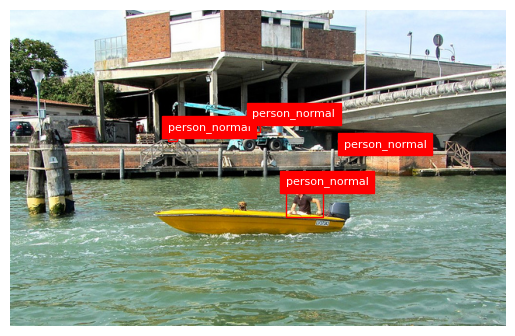

In [5]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pycocotools.coco import COCO

# Define paths
# annotations_file = 'combined_dataset/annotations/instances_train2017.json'  # or your train/test annotations file
# images_dir = 'combined_dataset/train2017'  # or your train/test images directory

annotations_file = 'combined_dataset/annotations/instances_test2017.json'  # or your test/test annotations file
images_dir = 'combined_dataset/test2017'  # or your test/test images directory


# Load COCO annotations
coco = COCO(annotations_file)

# Get all image IDs
image_ids = coco.getImgIds()

# Function to display image with annotations
def display_image_with_annotations(coco, image_id, images_dir):
    # Load image
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(images_dir, img_info['file_name'])
    image = Image.open(img_path)

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)

    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add annotations to the plot
    for ann in annotations:
        # Get bounding box coordinates
        bbox = ann['bbox']
        # Get category ID
        category_id = ann['category_id']
        # Get category name
        category_name = coco.loadCats(category_id)[0]['name']
        # Create a rectangle patch
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2],
            bbox[3],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        # Add category label
        plt.text(bbox[0], bbox[1], category_name, color='white', fontsize=8, backgroundcolor='red')

    plt.axis('off')  # Hide axes
    plt.show()

# Randomly select a few images to display
num_images_to_display = 5
selected_image_ids = random.sample(image_ids, num_images_to_display)

# Display the selected images with annotations
for image_id in selected_image_ids:
    display_image_with_annotations(coco, image_id, images_dir)
